# Quanvolutional Neural Networks

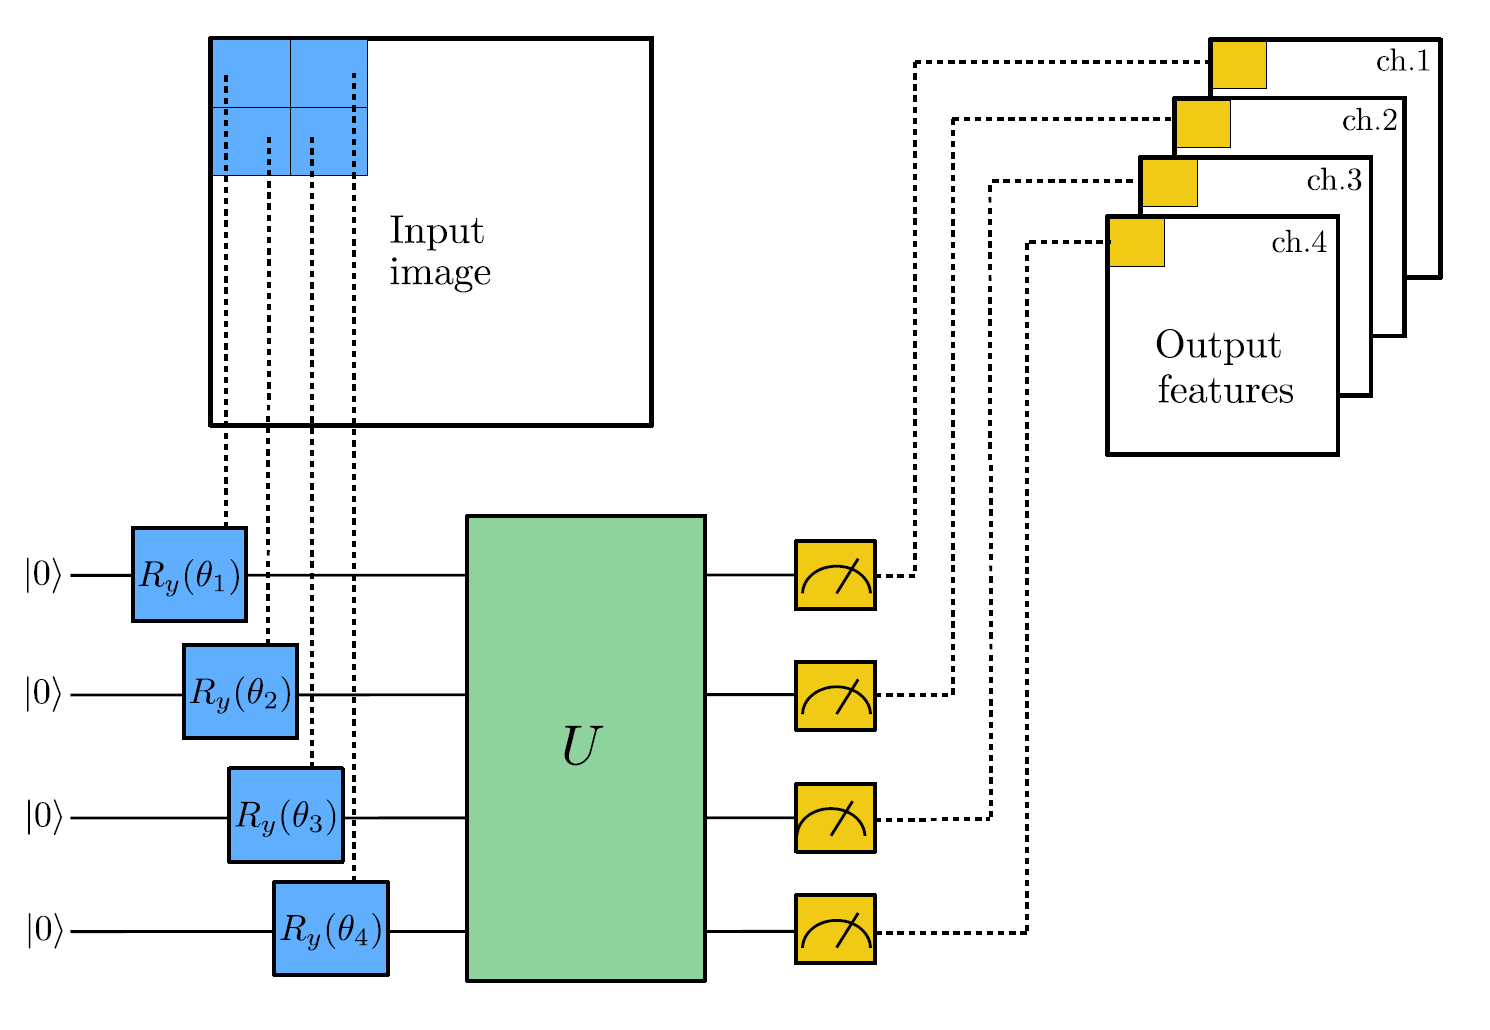

## Introduction

### Quantum Convolution

One can extend the idea of CNN also to the context of quantum variational circuits. A possible approach is given by the above image.

A quantum computation, associated to a unitary $U$, is performed on the system. The unitary could be generated by a variational quantum circuit or, more simply, by a random circuit.

The quantum system is finally measured, obtaining a list of classical expectation values. The measurement results could also be classically post-processed.

Analogously to a classical convolution layer, each expectation value is mapped to a different channel of a single output pixel.

Iterating the same procedure over different regions, one can scan the full input image, producing an output object which will be structured as a multi-channel image.

The quantum convolution can be followed by further quantum layers or by classical layers.

The main difference with respect to a classical convolution is that a quantum circuit can generate highly complex kernels whose computation could be, at least in principle, classically intractable.

### Installing and Importing Libraries

In [ ]:
%pip install tensorflow
%pip install pennylane
%pip install matplotlib

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

### Setting the Hyper-Parameters

In [2]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 50    # Size of the train dataset
n_test = 30     # Size of the test dataset

SAVE_PATH = "qnn/"  # Data saving folder
PREPROCESS = True  # If False, skip quantum processing and load data from SAVE_PATH

Set random seeds for reproducibility

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

### MNIST Dataset

In [4]:
mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Reduce dataset size

In [5]:
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

Normalize pixel values

In [6]:
train_images = train_images / 255
test_images = test_images / 255

Add extra dimension for the convolution channels

In [7]:
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

### Quantum Circuit as a convolution kernel

We create a 4-qubit device. The data is scaled and rotated, and then added a random circuit of 4 layers.

In [8]:
dev = qml.device("default.qubit", wires=4)

In [9]:
rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 4))

@qml.qnode(dev)
def qc(phi):
    # Encoding of 4 classical input values
    for j in range(4):
        qml.RY(np.pi * phi[j], wires=j)

    # Random quantum circuit
    RandomLayers(rand_params, wires=list(range(4)))

    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(4)]

Quantum Convolution Scheme function

In [10]:
def quanv(image):
    """Convolves the input image with many applications of the same quantum circuit."""
    out = np.zeros((14, 14, 4))

    for j in range(0, 28, 2):
        for k in range(0, 28, 2):
            q_results = qc([
                image[j, k, 0],
                image[j, k + 1, 0],
                image[j + 1, k, 0],
                image[j + 1, k + 1, 0]
            ])
            for c in range(4):
                out[j // 2, k // 2, c] = q_results[c]
    return out

### Quantum Pre-Processing

In [12]:
if PREPROCESS:
    q_train_images = []
    print("Quantum pre-processing of train images:")
    for idx, img in enumerate(train_images):
        print("{}/{}        ".format(idx + 1, n_train), end="\r")
        q_train_images.append(quanv(img))
    q_train_images = np.asarray(q_train_images)

    q_test_images = []
    print("\nQuantum pre-processing of test images:")
    for idx, img in enumerate(test_images):
        print("{}/{}        ".format(idx + 1, n_test), end="\r")
        q_test_images.append(quanv(img))
    q_test_images = np.asarray(q_test_images)

    # Save pre-processed images
    np.save(SAVE_PATH + "q_train_images.npy", q_train_images)
    np.save(SAVE_PATH + "q_test_images.npy", q_test_images)


# Load pre-processed images
q_train_images = np.load(SAVE_PATH + "q_train_images.npy")
q_test_images = np.load(SAVE_PATH + "q_test_images.npy")

Quantum pre-processing of train images:
50/50        
Quantum pre-processing of test images:


### Visualizing Pre-Processed Data

Visualizing the effect of quantum convolution layer on a batch of samples

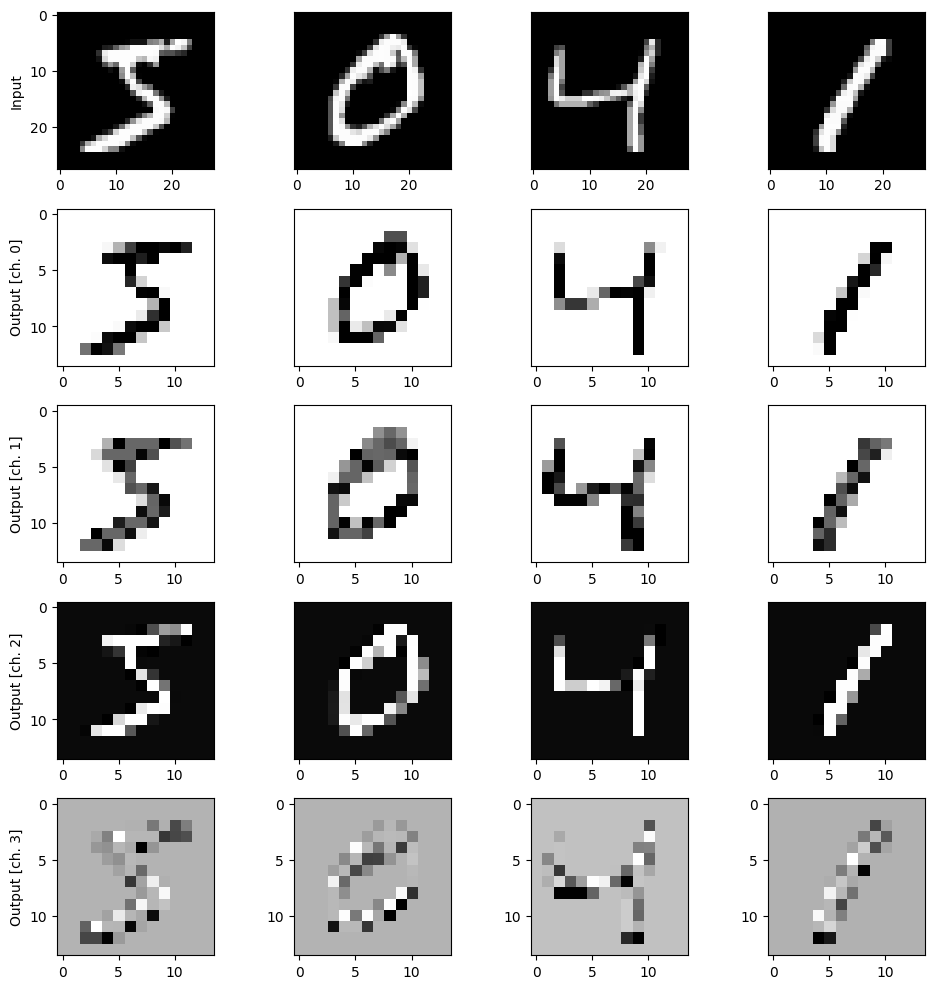

In [13]:
n_samples = 4
n_channels = 4
fig, axes = plt.subplots(1 + n_channels, n_samples, figsize=(10, 10))
for k in range(n_samples):
    axes[0, 0].set_ylabel("Input")
    if k != 0:
        axes[0, k].yaxis.set_visible(False)
    axes[0, k].imshow(train_images[k, :, :, 0], cmap="gray")

    # Plot all output channels
    for c in range(n_channels):
        axes[c + 1, 0].set_ylabel("Output [ch. {}]".format(c))
        if k != 0:
            axes[c, k].yaxis.set_visible(False)
        axes[c + 1, k].imshow(q_train_images[k, :, :, c], cmap="gray")

plt.tight_layout()
plt.show()

### Hybrid Quantum-Classical model

We take the output of the quanvolutional layer created earlier and feed it to a classical NN and train it for the MNIST classes.

In [14]:
def create_model():
    """Initializes and returns a custom Keras model ready to be trained."""
    model = keras.models.Sequential([
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])

    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

### Training the Quantum Model

Train the quantum model

In [15]:
q_model = create_model()
q_history = q_model.fit(
    q_train_images,
    train_labels,
    validation_data=(q_test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2
)

Epoch 1/30
13/13 - 1s - 68ms/step - accuracy: 0.1000 - loss: 2.6123 - val_accuracy: 0.2667 - val_loss: 2.2256
Epoch 2/30
13/13 - 0s - 5ms/step - accuracy: 0.3600 - loss: 1.9555 - val_accuracy: 0.2000 - val_loss: 2.1132
Epoch 3/30
13/13 - 0s - 6ms/step - accuracy: 0.5000 - loss: 1.7172 - val_accuracy: 0.3333 - val_loss: 1.8858
Epoch 4/30
13/13 - 0s - 5ms/step - accuracy: 0.6200 - loss: 1.4237 - val_accuracy: 0.4333 - val_loss: 1.7484
Epoch 5/30
13/13 - 0s - 5ms/step - accuracy: 0.7600 - loss: 1.1858 - val_accuracy: 0.5000 - val_loss: 1.6556
Epoch 6/30
13/13 - 0s - 5ms/step - accuracy: 0.8400 - loss: 1.0106 - val_accuracy: 0.6000 - val_loss: 1.5665
Epoch 7/30
13/13 - 0s - 5ms/step - accuracy: 0.9200 - loss: 0.8644 - val_accuracy: 0.6667 - val_loss: 1.4921
Epoch 8/30
13/13 - 0s - 5ms/step - accuracy: 0.9600 - loss: 0.7421 - val_accuracy: 0.6667 - val_loss: 1.4353
Epoch 9/30
13/13 - 0s - 5ms/step - accuracy: 0.9600 - loss: 0.6433 - val_accuracy: 0.6667 - val_loss: 1.3869
Epoch 10/30
13/13 

### Training the Baseline Model

Train the classical model for comparison

In [16]:
c_model = create_model()

c_history = c_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size=4,
    epochs=n_epochs,
    verbose=2,
)

Epoch 1/30
13/13 - 1s - 52ms/step - accuracy: 0.1600 - loss: 2.2659 - val_accuracy: 0.0667 - val_loss: 2.2493
Epoch 2/30
13/13 - 0s - 6ms/step - accuracy: 0.4200 - loss: 1.8435 - val_accuracy: 0.2333 - val_loss: 2.0632
Epoch 3/30
13/13 - 0s - 5ms/step - accuracy: 0.6000 - loss: 1.5587 - val_accuracy: 0.4667 - val_loss: 1.9121
Epoch 4/30
13/13 - 0s - 5ms/step - accuracy: 0.7600 - loss: 1.3389 - val_accuracy: 0.4667 - val_loss: 1.7835
Epoch 5/30
13/13 - 0s - 5ms/step - accuracy: 0.8200 - loss: 1.1587 - val_accuracy: 0.5000 - val_loss: 1.6758
Epoch 6/30
13/13 - 0s - 6ms/step - accuracy: 0.8600 - loss: 1.0087 - val_accuracy: 0.5333 - val_loss: 1.5882
Epoch 7/30
13/13 - 0s - 6ms/step - accuracy: 0.8800 - loss: 0.8840 - val_accuracy: 0.5333 - val_loss: 1.5171
Epoch 8/30
13/13 - 0s - 5ms/step - accuracy: 0.9000 - loss: 0.7798 - val_accuracy: 0.5667 - val_loss: 1.4584
Epoch 9/30
13/13 - 0s - 5ms/step - accuracy: 0.9200 - loss: 0.6919 - val_accuracy: 0.6333 - val_loss: 1.4091
Epoch 10/30
13/13 

### Results

Plotting accuracy and loss comparison

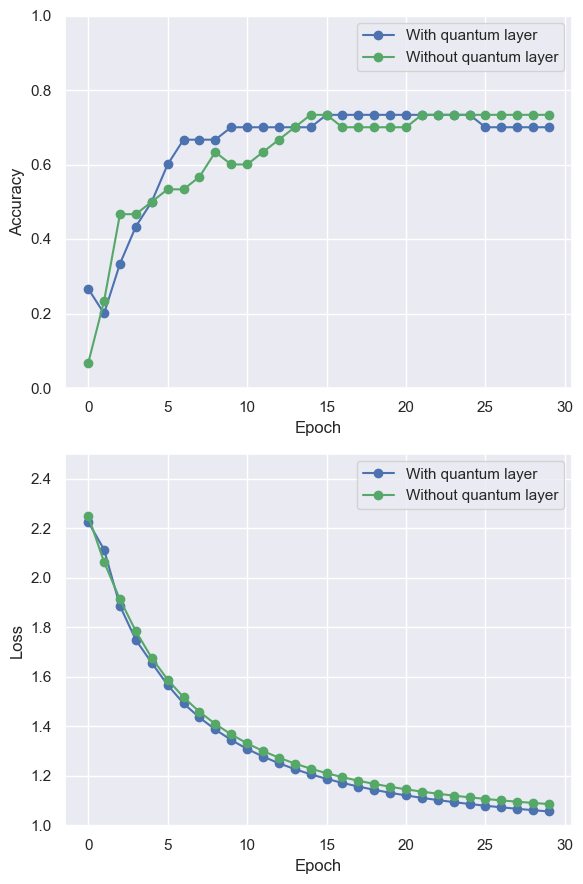

In [23]:
import matplotlib.pyplot as plt 
import seaborn as sns

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 9))

# sns.set()
ax1.plot(q_history.history["val_accuracy"], "-ob", label="With quantum layer")
ax1.plot(c_history.history["val_accuracy"], "-og", label="Without quantum layer")
ax1.set_ylabel("Accuracy")
ax1.set_ylim([0, 1])
ax1.set_xlabel("Epoch")
ax1.legend()

ax2.plot(q_history.history["val_loss"], "-ob", label="With quantum layer")
ax2.plot(c_history.history["val_loss"], "-og", label="Without quantum layer")
ax2.set_ylabel("Loss")
ax2.set_ylim(top=2.5)
ax2.set_xlabel("Epoch")
ax2.legend()

plt.tight_layout()
plt.show()

### Summary

The QNN model has been successfully created and trained on the MNIST dataset.